In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras import regularizers
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from tensorflow.keras.optimizers import SGD


sns.set_theme()
sns.set_context("paper")

tf.random.set_seed(0)
np.random.seed(0)

%matplotlib widget

## TarNet implementation

This implementation is from [this tutorial](https://bernardjkoch.com/dlci/). It uses Tensorflow 2's functional API. There is one small tweak: I added one representation layer with output size 2, in order to observe it visually.

In [2]:
def make_tarnet(input_dim, reg_l2):
    '''
    The first argument is the column dimension of our data.
    It needs to be specified because the functional API creates a static computational graph
    The second argument is the strength of regularization we'll apply to the output layers
    '''
    x = Input(shape=(input_dim,), name='input')

    # REPRESENTATION
    #in TF2/Keras it is idiomatic to instantiate a layer and pass its inputs on the same line unless the layer will be reused
    #Note that we apply no regularization to the representation layers 
    phi = Dense(units=20, activation='elu', kernel_initializer='RandomNormal', name='phi_hidden_1')(x)
    phi = Dense(units=20, activation='elu', kernel_initializer='RandomNormal', name='phi_hidden_2')(phi)
    phi = Dense(units=20, activation='elu', kernel_initializer='RandomNormal', name='phi_hidden_3')(phi)
    phi = Dense(units=2, activation='elu', kernel_initializer='RandomNormal', name='phi')(phi)

    # HYPOTHESIS
    y0_hidden = Dense(units=20, activation='elu', kernel_regularizer=regularizers.l2(reg_l2),name='y0_hidden_1')(phi)
    y1_hidden = Dense(units=20, activation='elu', kernel_regularizer=regularizers.l2(reg_l2),name='y1_hidden_1')(phi)

    # second layer
    y0_hidden = Dense(units=20, activation='elu', kernel_regularizer=regularizers.l2(reg_l2),name='y0_hidden_2')(y0_hidden)
    y1_hidden = Dense(units=20, activation='elu', kernel_regularizer=regularizers.l2(reg_l2),name='y1_hidden_2')(y1_hidden)

    # third
    y0_predictions = Dense(units=1, activation=None, kernel_regularizer=regularizers.l2(reg_l2), name='y0_predictions')(y0_hidden)
    y1_predictions = Dense(units=1, activation=None, kernel_regularizer=regularizers.l2(reg_l2), name='y1_predictions')(y1_hidden)

    #a convenience "layer" that concatenates arrays as columns in a matrix
    concat_pred = Concatenate(1)([y0_predictions, y1_predictions, phi])
    #the declarations above have specified the computational graph of our network, now we instantiate it
    model = Model(inputs=x, outputs=concat_pred)

    return model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 2)]          0                                            
__________________________________________________________________________________________________
phi_hidden_1 (Dense)            (None, 20)           60          input[0][0]                      
__________________________________________________________________________________________________
phi_hidden_2 (Dense)            (None, 20)           420         phi_hidden_1[0][0]               
__________________________________________________________________________________________________
phi_hidden_3 (Dense)            (None, 20)           420         phi_hidden_2[0][0]               
______________________________________________________________________________________________

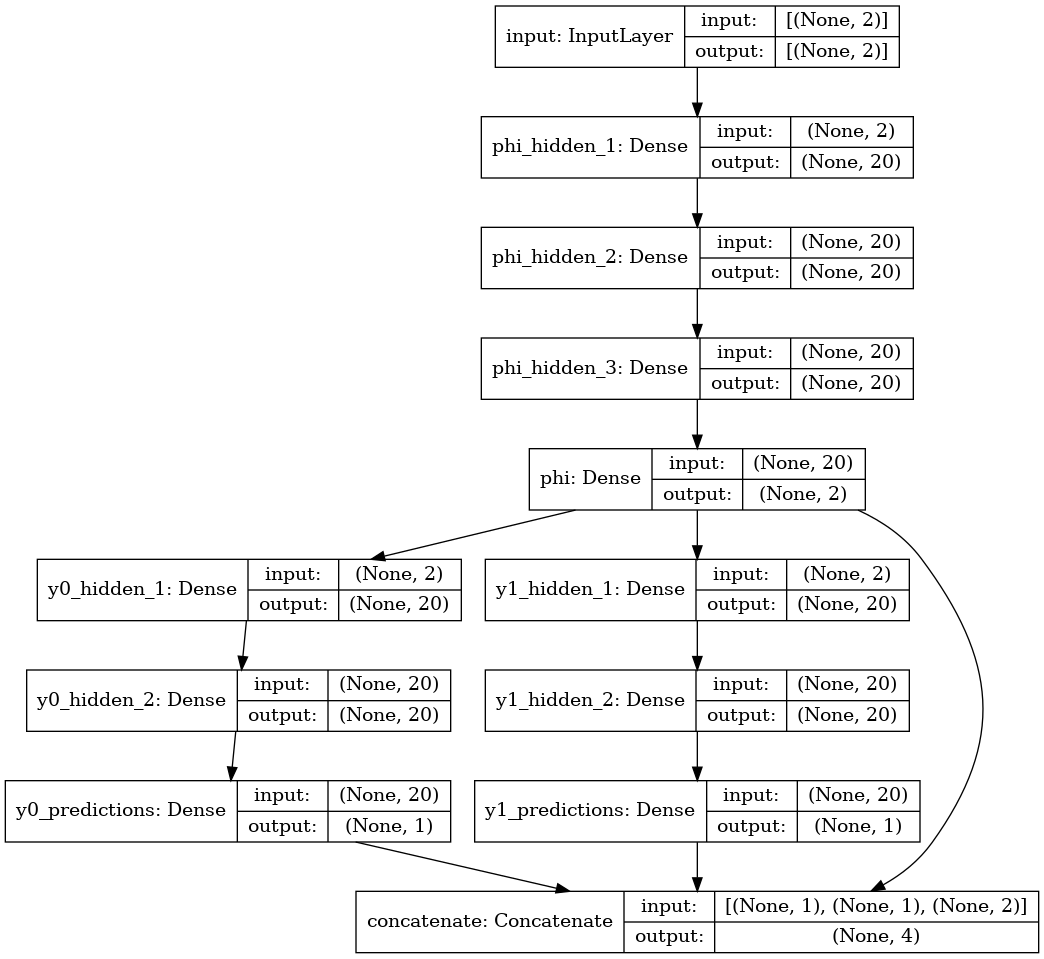

In [3]:
tarnet_model=make_tarnet(2,.01)

print(tarnet_model.summary())
tf.keras.utils.plot_model(tarnet_model, show_shapes=True, show_layer_names=True, to_file='tarnet.png')

from IPython.display import Image # this just Jupyter notebook stuff
Image(retina=True, filename='tarnet.png')

In [4]:
# every loss function in TF2 takes 2 arguments, a vector of true values and a vector predictions
def regression_loss(concat_true, concat_pred):
    #computes a standard MSE loss for TARNet
    y_true = concat_true[:, 0] #get individual vectors
    t_true = concat_true[:, 1]

    y0_pred = concat_pred[:, 0]
    y1_pred = concat_pred[:, 1]

    #Each head outputs a prediction for both potential outcomes
    #We use t_true as a switch to only calculate the factual loss
    loss0 = tf.reduce_sum((1. - t_true) * tf.square(y_true - y0_pred))
    loss1 = tf.reduce_sum(t_true * tf.square(y_true - y1_pred))
    #note Shi uses tf.reduce_sum for her losses instead of tf.reduce_mean.
    #They should be equivalent but it's possible that having larger gradients accelerates convergence.
    #You can always try changing it!
    return loss0 + loss1

## Generating the data

My idea is to have the data be generated by a pre-defined model with covariates being 2-dimensional and forcing the final representation layer to be also 2-dimensional. I will try different models, but they all will follow an equation like this

$Y = X_1 + X_2 + T + \epsilon$,

where $\mathbb{E} \epsilon = 0$. The first law we will try will be this simple linear equation, but others will also be tested. I will also generate samples $X$ with some hypothesis about control and treated groups, so I can introduce confounding to the problem. I chose the following rules, but other hypothesis could be made and studied as well.

$X_{1, \text{control}} \sim N (0, 1)$

$X_{2, \text{control}} \sim N (0, 1)$

$X_{1, \text{treated}} \sim N (1, 1)$

$X_{2, \text{treated}} \sim N (1, 1)$

and 

$\epsilon \sim N (0, 1)$.

So $X_{1, 2}$ could also be defined as

$X_{1, 2} = T + Z$,

with $Z \sim N (0, 1)$.

In [5]:
N = 5000


X_1_c = np.random.normal(0, 1, N).reshape(-1, 1)
X_2_c = np.random.normal(0, 1, N).reshape(-1, 1)
control = np.concatenate((X_1_c, X_2_c), axis=1)

X_1_t = np.random.normal(1, 1, N).reshape(-1, 1)
X_2_t = np.random.normal(1, 1, N).reshape(-1, 1)
treated = np.concatenate((X_1_t, X_2_t), axis=1)

X = np.concatenate((control, treated), axis=0)
X_1 = X[:, [0]]
X_2 = X[:, [1]]
T = np.concatenate((np.zeros_like(X_1_c), np.zeros_like(X_1_t) + 1), axis=0)
epsilon = np.random.normal(0, 1, N*2).reshape(-1, 1)

In [6]:
y = X_1 + X_2 + T + epsilon
y_1 = X_1 + X_2 + 1 + epsilon
y_0 = X_1 + X_2 + epsilon
x_axis = X_1 + X_2
x_label = '$X_1 + X_2$'

Here I'm creating a dataframe in order to visualize the format of the dataset that was generated.

In [7]:
df = pd.DataFrame(y).rename(columns={0: 'y'})
df = df.merge(pd.DataFrame(y_1).rename(columns={0: 'y1'}), right_index=True, left_index=True, how='inner')
df = df.merge(pd.DataFrame(y_0).rename(columns={0: 'y0'}), right_index=True, left_index=True, how='inner')
df = df.merge(pd.DataFrame(X[:, [0]]).rename(columns={0: 'X1'}), right_index=True, left_index=True, how='inner')
df = df.merge(pd.DataFrame(X[:, [1]]).rename(columns={0: 'X_2'}), right_index=True, left_index=True, how='inner')
df = df.merge(pd.DataFrame(T).rename(columns={0: 'T'}), right_index=True, left_index=True, how='inner')
df

,y,y1,y0,X1,X_2,T
0,2.403822,3.403822,2.403822,1.764052,0.309724,0.0
1,-0.337779,0.662221,-0.337779,0.400157,-0.737456,0.0
2,0.259934,1.259934,0.259934,0.978738,-1.536920,0.0
3,2.106852,3.106852,2.106852,2.240893,-0.562255,0.0
4,-2.235900,-1.235900,-2.235900,1.867558,-1.599511,0.0
...,...,...,...,...,...,...
9995,3.499206,3.499206,2.499206,1.628442,1.271662,1.0
9996,4.144432,4.144432,3.144432,2.838881,0.891003,1.0
9997,2.184559,2.184559,1.184559,1.753094,0.942741,1.0
9998,2.336880,2.336880,1.336880,0.418967,-0.058931,1.0


In [8]:
plt.figure()

plt.scatter(X_1_t, X_2_t, label='Treated group', marker='.', color='blue', s=1)
plt.scatter(X_1_c, X_2_c, label='Control group', marker='.', color='red', s=1)
plt.ylabel('$X_2$').set_rotation(0)
plt.xlabel('$X_1$')
plt.title('Treated and control populations')
plt.legend();

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [9]:
def plot_potential_outcomes(size=50):
    markersize = 70

    y_factual_c = y_0[:size]
    y_factual_t = y_1[N:N+size]
    y_counterfactual_c = y_1[:size]
    y_counterfactual_t = y_0[N:N+size]

    plt.figure(figsize=(10,5))


    plt.scatter(x_axis[:size], y_factual_c, marker='o', color='red', label='Factual-Control', s=markersize)
    plt.scatter(x_axis[:size], y_counterfactual_c, marker='o', color='blue', alpha=0.3, label='Counterfactual-Control', s=markersize)
    plt.scatter(x_axis[N:N+size], y_factual_t, marker='o', color='blue', label='Factual-Treated', s=markersize)
    plt.scatter(x_axis[N:N+size], y_counterfactual_t, marker='o', color='red', alpha=0.3, label='Counterfactual-Treated', s=markersize)

    for i in range(size):
        if i == 0:
            label = 'ITE'
        else:
            label=None
        plt.plot([x_axis[i][0], x_axis[i][0]], 
                 [y_factual_c[i][0], y_counterfactual_c[i][0]], 
                 '--', color='black', linewidth=0.7, alpha=0.8, label=label)
        plt.plot([x_axis[N+i][0], x_axis[N+i][0]], 
                 [y_factual_t[i][0], y_counterfactual_t[i][0]], 
                 '--', color='black', linewidth=0.7, alpha=0.8)

    plt.legend()
    plt.ylabel('$Y$').set_rotation(0)
    plt.xlabel(x_label)
    plt.title('Potential outcomes');
    
plot_potential_outcomes()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [10]:
def run_tarnet():
    val_split=0.2
    batch_size=64
    verbose=1
    scaler = StandardScaler().fit(y)
    ys = scaler.transform(y)
    yt = np.concatenate([ys, T], 1) #we'll use both y and t to compute the loss


    sgd_callbacks = [
            TerminateOnNaN(),
            EarlyStopping(monitor='val_loss', patience=40, min_delta=0.), 
            #40 is Shi's recommendation for this dataset, but you should tune for your data 
            ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=verbose, mode='auto',
                              min_delta=0., cooldown=0, min_lr=0),
        ]
    #optimzier hyperparameters
    sgd_lr = 1e-5
    momentum = 0.9
    tarnet_model.compile(optimizer=SGD(learning_rate=sgd_lr, momentum=momentum, nesterov=True),
                         loss=regression_loss,
                         metrics=regression_loss)

    tarnet_model.fit(x=X, y=yt,
                     callbacks=sgd_callbacks,
                     validation_split=val_split,
                     epochs=300,
                     batch_size=batch_size,
                     verbose=verbose)
    print("DONE!")
    return tarnet_model, scaler

tarnet_model, scaler = run_tarnet()

Epoch 1/300
125/125 [==============================] - 1s 2ms/step - loss: 41.9890 - regression_loss: 41.4750 - val_loss: 36.2746 - val_regression_loss: 35.2813
Epoch 2/300
125/125 [==============================] - 0s 1ms/step - loss: 36.5386 - regression_loss: 36.0240 - val_loss: 36.1620 - val_regression_loss: 35.1597
Epoch 3/300
125/125 [==============================] - 0s 1ms/step - loss: 36.5135 - regression_loss: 35.9991 - val_loss: 36.1483 - val_regression_loss: 35.1406
Epoch 4/300
125/125 [==============================] - 0s 1ms/step - loss: 36.5025 - regression_loss: 35.9883 - val_loss: 36.1687 - val_regression_loss: 35.1692
Epoch 5/300
125/125 [==============================] - 0s 1ms/step - loss: 36.5184 - regression_loss: 36.0045 - val_loss: 36.1401 - val_regression_loss: 35.1338
Epoch 6/300
125/125 [==============================] - 0s 1ms/step - loss: 36.5069 - regression_loss: 35.9932 - val_loss: 36.1358 - val_regression_loss: 35.1301
Epoch 7/300
125/125 [=============

125/125 [==============================] - 0s 1ms/step - loss: 13.0851 - regression_loss: 12.5517 - val_loss: 13.5258 - val_regression_loss: 12.7891
Epoch 52/300
125/125 [==============================] - 0s 1ms/step - loss: 13.0583 - regression_loss: 12.5248 - val_loss: 13.3910 - val_regression_loss: 12.6609
Epoch 53/300
125/125 [==============================] - 0s 1ms/step - loss: 13.0438 - regression_loss: 12.5101 - val_loss: 13.3646 - val_regression_loss: 12.6333
Epoch 54/300
125/125 [==============================] - 0s 1ms/step - loss: 13.0342 - regression_loss: 12.5004 - val_loss: 13.3907 - val_regression_loss: 12.6550
Epoch 55/300
125/125 [==============================] - 0s 1ms/step - loss: 13.0199 - regression_loss: 12.4861 - val_loss: 13.3113 - val_regression_loss: 12.5787
Epoch 56/300
125/125 [==============================] - 0s 1ms/step - loss: 13.0077 - regression_loss: 12.4738 - val_loss: 13.3258 - val_regression_loss: 12.5901
Epoch 57/300
125/125 [===================

125/125 [==============================] - 0s 1ms/step - loss: 12.7460 - regression_loss: 12.2132 - val_loss: 12.8262 - val_regression_loss: 12.0861
Epoch 102/300
125/125 [==============================] - 0s 1ms/step - loss: 12.7476 - regression_loss: 12.2150 - val_loss: 12.8304 - val_regression_loss: 12.0895
Epoch 103/300
125/125 [==============================] - 0s 1ms/step - loss: 12.7394 - regression_loss: 12.2068 - val_loss: 12.8819 - val_regression_loss: 12.1389
Epoch 104/300
125/125 [==============================] - 0s 1ms/step - loss: 12.7623 - regression_loss: 12.2298 - val_loss: 12.8505 - val_regression_loss: 12.1080
Epoch 105/300
125/125 [==============================] - 0s 1ms/step - loss: 12.7406 - regression_loss: 12.2083 - val_loss: 12.7950 - val_regression_loss: 12.0590
Epoch 106/300
125/125 [==============================] - 0s 1ms/step - loss: 12.7604 - regression_loss: 12.2281 - val_loss: 12.7757 - val_regression_loss: 12.0388
Epoch 107/300
125/125 [=============

125/125 [==============================] - 0s 1ms/step - loss: 12.6880 - regression_loss: 12.1568 - val_loss: 12.7476 - val_regression_loss: 12.0089
Epoch 150/300
125/125 [==============================] - 0s 1ms/step - loss: 12.6898 - regression_loss: 12.1586 - val_loss: 12.7458 - val_regression_loss: 12.0072
Epoch 151/300
125/125 [==============================] - 0s 1ms/step - loss: 12.6888 - regression_loss: 12.1576 - val_loss: 12.7404 - val_regression_loss: 12.0023
Epoch 152/300
125/125 [==============================] - 0s 1ms/step - loss: 12.6869 - regression_loss: 12.1558 - val_loss: 12.7524 - val_regression_loss: 12.0133
Epoch 153/300
125/125 [==============================] - 0s 1ms/step - loss: 12.6884 - regression_loss: 12.1573 - val_loss: 12.7438 - val_regression_loss: 12.0054
Epoch 154/300
125/125 [==============================] - 0s 1ms/step - loss: 12.6900 - regression_loss: 12.1589 - val_loss: 12.7470 - val_regression_loss: 12.0083
Epoch 155/300
125/125 [=============

Epoch 198/300
125/125 [==============================] - 0s 1ms/step - loss: 12.6833 - regression_loss: 12.1523 - val_loss: 12.7417 - val_regression_loss: 12.0032
Epoch 199/300
125/125 [==============================] - 0s 1ms/step - loss: 12.6835 - regression_loss: 12.1525 - val_loss: 12.7414 - val_regression_loss: 12.0029
Epoch 200/300
125/125 [==============================] - 0s 1ms/step - loss: 12.6835 - regression_loss: 12.1525 - val_loss: 12.7419 - val_regression_loss: 12.0034
Epoch 201/300
125/125 [==============================] - 0s 1ms/step - loss: 12.6833 - regression_loss: 12.1523 - val_loss: 12.7421 - val_regression_loss: 12.0036
Epoch 202/300
125/125 [==============================] - 0s 1ms/step - loss: 12.6832 - regression_loss: 12.1521 - val_loss: 12.7422 - val_regression_loss: 12.0037
Epoch 203/300
125/125 [==============================] - 0s 1ms/step - loss: 12.6834 - regression_loss: 12.1524 - val_loss: 12.7424 - val_regression_loss: 12.0038
Epoch 204/300
125/125 

In [11]:
def predict_ate():
    concat_pred = tarnet_model.predict(X)

    y0_pred = scaler.inverse_transform(concat_pred[:, 0])
    y1_pred = scaler.inverse_transform(concat_pred[:, 1])

    cate_pred = y1_pred - y0_pred
    cate_true = y_1.reshape(1, -1) - y_0.reshape(1, -1)
    ate_pred = tf.reduce_mean(cate_pred)

    print('Estimated ATE: ', ate_pred.numpy())
    print('Expected ATE: ', np.mean(y_1 - y_0))
    
predict_ate()

Estimated ATE:  0.99060684
Expected ATE:  1.0


In [12]:
def inspect_representations(model_type='linear'):
    control_pred = tarnet_model.predict(X[:N])
    treated_pred = tarnet_model.predict(X[N:])

    phi_1_c = control_pred[:, 2]
    phi_2_c = control_pred[:, 3]
    phi_1_t = treated_pred[:, 2]
    phi_2_t = treated_pred[:, 3]
    
    phi_1 = np.concatenate((phi_1_c, phi_1_t), axis=0)
    phi_2 = np.concatenate((phi_2_c, phi_2_t), axis=0)
    
    y_c_fact = control_pred[:, 0]
    y_c_counter = control_pred[:, 1]
    y_t_fact = treated_pred[:, 1]
    y_t_counter = treated_pred[:, 0]
    
    y_1 = np.concatenate((y_c_counter, y_t_fact), axis=0)
    y_0 = np.concatenate((y_c_fact, y_t_counter), axis=0)
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=False, figsize=(9,9))

    ax1.scatter(phi_1_t, phi_2_t, label='Treated group', marker='.', color='blue', s=1)
    ax1.scatter(phi_1_c, phi_2_c, label='Control group', marker='.', color='red', s=1)
    ax1.set_ylabel('$\Phi(X)_2$').set_rotation(0)
    ax1.set_xlabel('$\Phi(X)_1$')
    ax1.set_title('Representation Space')
    ax1.legend()
    
    if model_type == 'linear':
        x = phi_1 + phi_2
        label = "$\Phi_1(X) + \Phi_2(X)$"
    elif model_type == 'quadratic':
        x = phi_1 - phi_1**2 - phi_2 + phi_2**2  
        label = "$\Phi_1(X) - \Phi_1(X)^2 - \Phi_2(X) + \Phi_2(X)^2$"   
    
    ax2.scatter(x, y_1, label='$Y_1$', marker='.', color='blue', s=1)
    ax2.scatter(x, y_0, label='$Y_0$', marker='.', color='red', s=1)
    ax2.set_ylabel('$Y$').set_rotation(0)
    ax2.set_xlabel(label)
    ax2.set_title('Potential outcomes from representation')
    ax2.legend()
    
    ax3.scatter(phi_1, y_1, label='$Y_1$', marker='.', color='blue', s=1)
    ax3.scatter(phi_1, y_0, label='$Y_0$', marker='.', color='red', s=1)
    ax3.set_ylabel('$Y$').set_rotation(0)
    ax3.set_xlabel('$\Phi_1$')
    ax3.set_title('Potential outcomes from $\Phi_1$')
    ax3.legend()
    
    ax4.scatter(phi_2, y_1, label='$Y_1$', marker='.', color='blue', s=1)
    ax4.scatter(phi_2, y_0, label='$Y_0$', marker='.', color='red', s=1)
    ax4.set_ylabel('$Y$').set_rotation(0)
    ax4.set_xlabel('$\Phi_2$')
    ax4.set_title('Potential outcomes from $\Phi_2$')
    ax4.legend()
    
    plt.tight_layout();
    
inspect_representations()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Now let's try different laws for generating $Y$. The first one will be adding a cross-term $X_1 T$

$Y = X_1 + X_2 + T + \frac12 T X_1 + \epsilon$

In [13]:
y = X_1 + X_2 + T + epsilon + 0.5 * X_1 * T
y_1 = X_1 + X_2 + 1 + epsilon + 0.5 * X_1
y_0 = X_1 + X_2 + epsilon
x_axis = X_1 + X_2
x_label = '$X_1 + X_2$'

In [14]:
plot_potential_outcomes()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [15]:
tarnet_model, scaler = run_tarnet()

Epoch 1/300
125/125 [==============================] - 1s 2ms/step - loss: 10.6238 - regression_loss: 10.0929 - val_loss: 10.6189 - val_regression_loss: 9.9238
Epoch 2/300
125/125 [==============================] - 0s 1ms/step - loss: 10.4387 - regression_loss: 9.9079 - val_loss: 10.3958 - val_regression_loss: 9.7011
Epoch 3/300
125/125 [==============================] - 0s 1ms/step - loss: 10.3744 - regression_loss: 9.8436 - val_loss: 10.3794 - val_regression_loss: 9.6808
Epoch 4/300
125/125 [==============================] - 0s 1ms/step - loss: 10.3521 - regression_loss: 9.8215 - val_loss: 10.3826 - val_regression_loss: 9.6879
Epoch 5/300
125/125 [==============================] - 0s 1ms/step - loss: 10.3558 - regression_loss: 9.8252 - val_loss: 10.3242 - val_regression_loss: 9.6280
Epoch 6/300
125/125 [==============================] - 0s 1ms/step - loss: 10.3469 - regression_loss: 9.8164 - val_loss: 10.2988 - val_regression_loss: 9.6028
Epoch 7/300
125/125 [========================

125/125 [==============================] - 0s 1ms/step - loss: 10.2115 - regression_loss: 9.6863 - val_loss: 10.2200 - val_regression_loss: 9.5277
Epoch 52/300
125/125 [==============================] - 0s 1ms/step - loss: 10.2083 - regression_loss: 9.6832 - val_loss: 10.1935 - val_regression_loss: 9.5033
Epoch 53/300
125/125 [==============================] - 0s 1ms/step - loss: 10.2073 - regression_loss: 9.6822 - val_loss: 10.1894 - val_regression_loss: 9.4996
Epoch 54/300
125/125 [==============================] - 0s 1ms/step - loss: 10.2073 - regression_loss: 9.6823 - val_loss: 10.2121 - val_regression_loss: 9.5202
Epoch 55/300
125/125 [==============================] - 0s 1ms/step - loss: 10.2094 - regression_loss: 9.6844 - val_loss: 10.1971 - val_regression_loss: 9.5067

Epoch 00055: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.
Epoch 56/300
125/125 [==============================] - 0s 1ms/step - loss: 10.2023 - regression_loss: 9.6774 - val_loss: 10.2050 - 

In [16]:
predict_ate()

Estimated ATE:  1.2451509
Expected ATE:  1.2476720917955524


In [17]:
inspect_representations()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Now let's add a negative term

$Y = X_1 + X_2 + T + \frac12 T X_1 - \frac12 (1 - T) X_2 + \epsilon$

In [18]:
y = X_1 + X_2 + T + epsilon + 0.5 * X_1 * T - 0.5 * X_2 * (1 - T)
y_1 = X_1 + X_2 + 1 + epsilon + 0.5 * X_1
y_0 = X_1 + X_2 + epsilon - 0.5 * X_2
x_axis = X_1 + X_2
x_label = '$X_1 + X_2$'

In [19]:
plot_potential_outcomes()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [20]:
run_tarnet()

Epoch 1/300
125/125 [==============================] - 1s 2ms/step - loss: 11.1013 - regression_loss: 10.5770 - val_loss: 11.0904 - val_regression_loss: 10.3924
Epoch 2/300
125/125 [==============================] - 0s 1ms/step - loss: 10.8782 - regression_loss: 10.3543 - val_loss: 10.9540 - val_regression_loss: 10.2555
Epoch 3/300
125/125 [==============================] - 0s 1ms/step - loss: 10.8223 - regression_loss: 10.2986 - val_loss: 10.9484 - val_regression_loss: 10.2439
Epoch 4/300
125/125 [==============================] - 0s 1ms/step - loss: 10.7942 - regression_loss: 10.2707 - val_loss: 10.8519 - val_regression_loss: 10.1542
Epoch 5/300
125/125 [==============================] - 0s 1ms/step - loss: 10.7940 - regression_loss: 10.2708 - val_loss: 10.8428 - val_regression_loss: 10.1425
Epoch 6/300
125/125 [==============================] - 0s 1ms/step - loss: 10.7819 - regression_loss: 10.2589 - val_loss: 10.8581 - val_regression_loss: 10.1547
Epoch 7/300
125/125 [=============

125/125 [==============================] - 0s 1ms/step - loss: 10.6771 - regression_loss: 10.1609 - val_loss: 10.7104 - val_regression_loss: 10.0144
Epoch 51/300
125/125 [==============================] - 0s 1ms/step - loss: 10.6807 - regression_loss: 10.1646 - val_loss: 10.7324 - val_regression_loss: 10.0350
Epoch 52/300
125/125 [==============================] - 0s 1ms/step - loss: 10.6773 - regression_loss: 10.1612 - val_loss: 10.7150 - val_regression_loss: 10.0190
Epoch 53/300
125/125 [==============================] - 0s 1ms/step - loss: 10.6754 - regression_loss: 10.1594 - val_loss: 10.7193 - val_regression_loss: 10.0238
Epoch 54/300
125/125 [==============================] - 0s 1ms/step - loss: 10.6787 - regression_loss: 10.1627 - val_loss: 10.7440 - val_regression_loss: 10.0461
Epoch 55/300
125/125 [==============================] - 0s 1ms/step - loss: 10.6775 - regression_loss: 10.1615 - val_loss: 10.7130 - val_regression_loss: 10.0172
Epoch 56/300
125/125 [===================

(<keras.engine.functional.Functional at 0x7f0c180b2310>, StandardScaler())

In [21]:
predict_ate()

Estimated ATE:  1.5515728
Expected ATE:  1.4962771428573394


In [22]:
inspect_representations()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Finally, we will introduce some quadratic terms and make our model more complex

$Y = X_1 - X_1^2 - X_2 + X_2^2 + T + TX_1 + (1-T)X_2$

In [23]:
y = X_1 - X_1**2 - X_2 + X_2**2 + T + epsilon + 0.5 * X_1 * T - 0.5 * X_1 * (1 - T)
y_1 = X_1 - X_1**2 - X_2 + X_2**2 + 1 + epsilon + 0.5 * X_1
y_0 = X_1 - X_1**2 - X_2 + X_2**2 + epsilon - 0.5 * X_1
x_axis = X_1 - X_2 - X_1**2 + X_2**2
x_label = '$X_1 - X_1^2 - X_2 + X_2^2$'

In [24]:
plot_potential_outcomes()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [25]:
run_tarnet()

Epoch 1/300
125/125 [==============================] - 1s 2ms/step - loss: 63.2976 - regression_loss: 62.7869 - val_loss: 59.2376 - val_regression_loss: 58.1438
Epoch 2/300
125/125 [==============================] - 0s 1ms/step - loss: 59.3267 - regression_loss: 58.8181 - val_loss: 57.8430 - val_regression_loss: 56.7799
Epoch 3/300
125/125 [==============================] - 0s 1ms/step - loss: 59.0671 - regression_loss: 58.5589 - val_loss: 57.1629 - val_regression_loss: 56.1108
Epoch 4/300
125/125 [==============================] - 0s 1ms/step - loss: 58.9107 - regression_loss: 58.4028 - val_loss: 56.5640 - val_regression_loss: 55.5225
Epoch 5/300
125/125 [==============================] - 0s 1ms/step - loss: 58.7226 - regression_loss: 58.2150 - val_loss: 55.4427 - val_regression_loss: 54.4057
Epoch 6/300
125/125 [==============================] - 0s 1ms/step - loss: 58.4501 - regression_loss: 57.9426 - val_loss: 53.9855 - val_regression_loss: 52.9361
Epoch 7/300
125/125 [=============

125/125 [==============================] - 0s 1ms/step - loss: 11.9466 - regression_loss: 11.4021 - val_loss: 13.1318 - val_regression_loss: 12.3665
Epoch 52/300
125/125 [==============================] - 0s 1ms/step - loss: 11.9367 - regression_loss: 11.3923 - val_loss: 12.3132 - val_regression_loss: 11.5523
Epoch 53/300
125/125 [==============================] - 0s 1ms/step - loss: 11.9061 - regression_loss: 11.3615 - val_loss: 14.1178 - val_regression_loss: 13.3258
Epoch 54/300
125/125 [==============================] - 0s 1ms/step - loss: 11.9104 - regression_loss: 11.3658 - val_loss: 12.5428 - val_regression_loss: 11.7743
Epoch 55/300
125/125 [==============================] - 0s 1ms/step - loss: 11.8446 - regression_loss: 11.3000 - val_loss: 12.3935 - val_regression_loss: 11.6245
Epoch 56/300
125/125 [==============================] - 0s 1ms/step - loss: 11.8503 - regression_loss: 11.3056 - val_loss: 13.2110 - val_regression_loss: 12.4316
Epoch 57/300
125/125 [===================

125/125 [==============================] - 0s 1ms/step - loss: 11.4877 - regression_loss: 10.9423 - val_loss: 12.2764 - val_regression_loss: 11.5084
Epoch 101/300
125/125 [==============================] - 0s 1ms/step - loss: 11.4666 - regression_loss: 10.9212 - val_loss: 11.9782 - val_regression_loss: 11.2171
Epoch 102/300
125/125 [==============================] - 0s 1ms/step - loss: 11.4785 - regression_loss: 10.9331 - val_loss: 11.8591 - val_regression_loss: 11.0959
Epoch 103/300
125/125 [==============================] - 0s 1ms/step - loss: 11.4678 - regression_loss: 10.9224 - val_loss: 12.0653 - val_regression_loss: 11.2971
Epoch 104/300
125/125 [==============================] - 0s 1ms/step - loss: 11.4736 - regression_loss: 10.9282 - val_loss: 11.9904 - val_regression_loss: 11.2253
Epoch 105/300
125/125 [==============================] - 0s 1ms/step - loss: 11.4351 - regression_loss: 10.8896 - val_loss: 11.8170 - val_regression_loss: 11.0591
Epoch 106/300
125/125 [=============

125/125 [==============================] - 0s 1ms/step - loss: 10.7983 - regression_loss: 10.2507 - val_loss: 10.9774 - val_regression_loss: 10.2267
Epoch 151/300
125/125 [==============================] - 0s 1ms/step - loss: 10.7701 - regression_loss: 10.2224 - val_loss: 11.1239 - val_regression_loss: 10.3685
Epoch 152/300
125/125 [==============================] - 0s 1ms/step - loss: 10.7511 - regression_loss: 10.2033 - val_loss: 10.7200 - val_regression_loss: 9.9754
Epoch 153/300
125/125 [==============================] - 0s 1ms/step - loss: 10.7482 - regression_loss: 10.2004 - val_loss: 10.8949 - val_regression_loss: 10.1440
Epoch 154/300
125/125 [==============================] - 0s 1ms/step - loss: 10.7076 - regression_loss: 10.1598 - val_loss: 10.7486 - val_regression_loss: 10.0027
Epoch 155/300
125/125 [==============================] - 0s 1ms/step - loss: 10.6713 - regression_loss: 10.1233 - val_loss: 10.8452 - val_regression_loss: 10.0971
Epoch 156/300
125/125 [==============

125/125 [==============================] - 0s 1ms/step - loss: 10.3608 - regression_loss: 9.8118 - val_loss: 10.4122 - val_regression_loss: 9.6746
Epoch 201/300
125/125 [==============================] - 0s 1ms/step - loss: 10.3827 - regression_loss: 9.8337 - val_loss: 10.5349 - val_regression_loss: 9.7928
Epoch 202/300
125/125 [==============================] - 0s 1ms/step - loss: 10.3678 - regression_loss: 9.8189 - val_loss: 10.6208 - val_regression_loss: 9.8761
Epoch 203/300
125/125 [==============================] - 0s 1ms/step - loss: 10.3479 - regression_loss: 9.7989 - val_loss: 10.4010 - val_regression_loss: 9.6656
Epoch 204/300
125/125 [==============================] - 0s 1ms/step - loss: 10.3668 - regression_loss: 9.8179 - val_loss: 10.5200 - val_regression_loss: 9.7783
Epoch 205/300
125/125 [==============================] - 0s 1ms/step - loss: 10.3619 - regression_loss: 9.8130 - val_loss: 10.3863 - val_regression_loss: 9.6499
Epoch 206/300
125/125 [=========================

125/125 [==============================] - 0s 1ms/step - loss: 10.2968 - regression_loss: 9.7479 - val_loss: 10.3765 - val_regression_loss: 9.6420
Epoch 249/300
125/125 [==============================] - 0s 1ms/step - loss: 10.2954 - regression_loss: 9.7465 - val_loss: 10.3771 - val_regression_loss: 9.6422
Epoch 250/300
125/125 [==============================] - 0s 1ms/step - loss: 10.2961 - regression_loss: 9.7472 - val_loss: 10.3756 - val_regression_loss: 9.6409
Epoch 251/300
125/125 [==============================] - 0s 1ms/step - loss: 10.2960 - regression_loss: 9.7471 - val_loss: 10.3765 - val_regression_loss: 9.6415
Epoch 252/300
125/125 [==============================] - 0s 1ms/step - loss: 10.2953 - regression_loss: 9.7464 - val_loss: 10.3749 - val_regression_loss: 9.6402
Epoch 253/300
125/125 [==============================] - 0s 1ms/step - loss: 10.2952 - regression_loss: 9.7463 - val_loss: 10.3775 - val_regression_loss: 9.6423
Epoch 254/300
125/125 [=========================

(<keras.engine.functional.Functional at 0x7f0c180b2310>, StandardScaler())

In [26]:
predict_ate()

Estimated ATE:  1.5148283
Expected ATE:  1.495344183591105


In [27]:
inspect_representations("quadratic")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Interpretations

From these visualizations, I understand that what TARNet does is actually not a *deconfounded* representation of the covariates. It is actually removing the noise and making a representation that in some way resembles the law from which the data were generated, and in which the differences between treated and control groups is visible. For instance, when we use linear models, the representations are straight lines. When $Y$ depends differently from $X_1$ and $X_2$ in a linear model, the lines cross. When the model has quadratic terms, we can see a parable in representation space.

I'm aware that using synthetic datasets like these is not a great measure of TARNet's success, because they may not resemble more fuzzy real-world datasets with higher-dimensions. The idea here was to force a simple dataset in order to be able to visualize the representation space, but more sophisticated methods that don't depend on this simplicity could be tried.

I also think that the same experiment should be tried with CFRNet, which tries to actively minimize the groups discrepancy in representation space. And also similar experiments could be done with dragonnet, e.g. making $X_2$ be agnostic of $T$ and seeing how much the representations really depend on it (because Dragonnet trades off treatment prediction and outcome prediction).